# Nedensel Etkiyi Hesaplamak İçin Temel Örnek

Bu, DoWhy nedensel çıkarım kütüphanesine hızlı bir giriş niteliğindedir. Bir örnek veri kümesi yükleyeceğiz ve (önceden belirlenmiş) bir tedavi değişkeninin (önceden belirlenmiş) bir sonuç değişkeni üzerindeki nedensel etkisini tahmin edeceğiz.

İlk olarak, gerekli tüm paketleri yükleyelim.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
from dowhy import CausalModel
import dowhy.datasets

In [2]:
data = dowhy.datasets.linear_dataset(beta=10,
        num_common_causes=5,
        num_instruments = 2,
        num_effect_modifiers=1,
        num_samples=5000,
        treatment_is_binary=True,
        stddev_treatment_noise=10,
        num_discrete_common_causes=1)

df = data["df"]

In [3]:
df.head()

,X0,Z0,Z1,W0,W1,W2,W3,W4,v0,y
0,-0.666238,0.0,0.063847,-0.008870,-0.864507,0.324024,0.596334,2,True,17.485291
1,-1.471120,0.0,0.779081,0.230885,-1.246081,0.752687,-0.472388,2,False,5.006673
2,-1.445403,0.0,0.896471,-0.852999,-0.745769,1.224934,-3.471034,2,True,6.342889
3,0.042316,0.0,0.295906,-0.698620,-0.880450,0.781316,-1.379829,3,True,15.910168
4,0.322697,1.0,0.947288,0.468601,1.014935,-0.556863,1.242844,3,True,32.263372


# 1.Arayüz 1 (önerilen): Girdi nedensel grafiği

Şimdi GML grafik biçiminde (önerilir) nedensel bir grafik giriyoruz. DOT biçimini de kullanabilirsiniz.

Veri kümeniz için nedensel grafiği oluşturmak için, grafiği oluşturmak üzere bir GUI sağlayan DAGitty gibi bir araç kullanabilirsiniz. Oluşturduğu grafik dizesini dışa aktarabilirsiniz. Grafik dizesi DOT biçimine çok yakındır: sadece dag'ı digraph olarak yeniden adlandırın, yeni satırları kaldırın ve her satırdan sonra bir noktalı virgül ekleyin, böylece DOT biçimine dönüştürün ve DoWhy'a girin.

In [4]:
model = CausalModel(
    data=df,
    treatment=data["treatment_name"],
    outcome=data["outcome_name"],
    graph=data["gml_graph"]
)

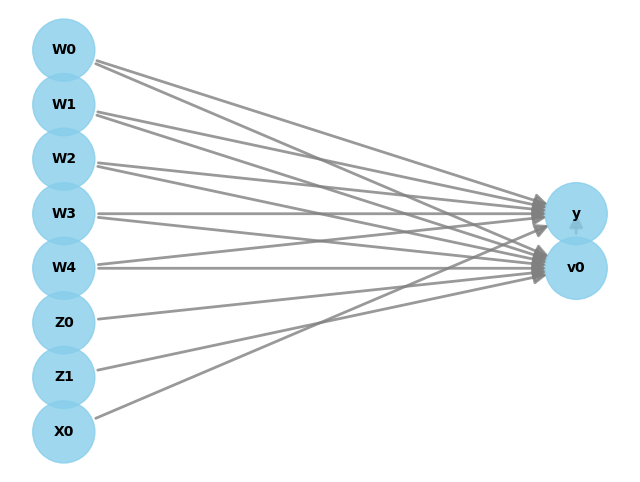

In [5]:
model.view_model()

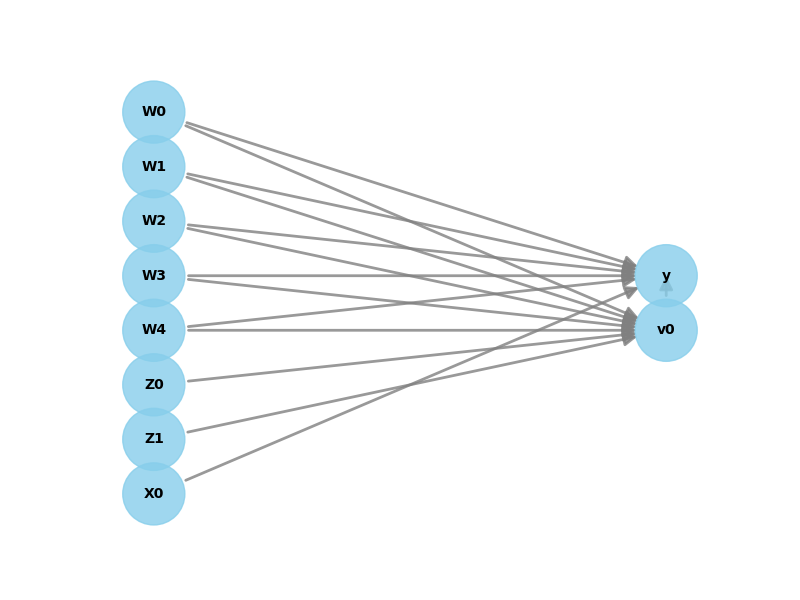

In [6]:
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

Yukarıdaki nedensel grafik, nedensel modelde kodlanmış varsayımları gösterir. Şimdi bu grafiği, önce nedensel etkiyi tanımlamak (nedensel bir tahminden olasılık ifadesine geçmek) ve sonra nedensel etkiyi tahmin etmek için kullanabiliriz.

**DoWhy felsefesi: Tanımlama (identification) ve tahmini (estimation) ayrı tutmak**.

Tanımlama, verilere erişim olmadan, yalnızca grafiğe erişerek gerçekleştirilebilir. Bu, hesaplanacak bir ifadeyle sonuçlanır. Bu ifade daha sonra tahmin adımındaki mevcut veriler kullanılarak değerlendirilebilir. Bunların ortogonal adımlar olduğunu anlamak önemlidir.

**Tanımlama**

In [6]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W1,W3,W2,W0,W4])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W3,W2,W0,W4,U) = P(y|v0,W1,W3,W2,W0,W4)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₀  Z₁]    ⎝d[Z₀  Z₁]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0,Z1})
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→{v0}, then ¬({Z0,Z1}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



proceed_when_unidentifiable parametresine dikkat edin. Gözlemlenmeyen herhangi bir karıştırıcıyı görmezden geldiğimizi varsaymak için True olarak ayarlanması gerekir. Varsayılan davranış, kullanıcıdan gözlemlenmeyen karıştırıcıların görmezden gelinebileceğini iki kez kontrol etmesini istemektir.

**Tahmin**

In [7]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_matching")
print(causal_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W1,W3,W2,W0,W4])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W3,W2,W0,W4,U) = P(y|v0,W1,W3,W2,W0,W4)

## Realized estimand
b: y~v0+W1+W3+W2+W0+W4
Target units: ate

## Estimate
Mean value: 9.975620441044288



estimate_effect yöntemine ek parametreler girebilirsiniz. Örneğin, birimlerin herhangi bir alt kümesindeki etkiyi tahmin etmek için, bir dize ("ate", "att" veya "atc") olabilen "target_units" parametresini, veri çerçevesinin satırlarını filtreleyen lambda fonksiyonunu veya etkiyi hesaplamak için yeni bir veri çerçevesini belirtebilirsiniz. Ayrıca, bu değişkenler arasında heterojen etkileri tahmin etmek için "etki değiştiricileri" de belirtebilirsiniz. Bkz. help(CausalModel.estimate_effect).

In [8]:
causal_estimate_att = model.estimate_effect(identified_estimand,
                                            method_name="backdoor.propensity_score_matching",
                                            target_units="atc")
print(causal_estimate_att)
print("Causal Estimate is " + str(causal_estimate.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W1,W3,W2,W0,W4])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W3,W2,W0,W4,U) = P(y|v0,W1,W3,W2,W0,W4)

## Realized estimand
b: y~v0+W1+W3+W2+W0+W4
Target units: atc

## Estimate
Mean value: 9.913693304550526

Causal Estimate is 9.975620441044288


# 2.Arayüz 2: Yaygın nedenleri ve araç değişkenleri belirtin

In [9]:
model = CausalModel(
    data=df,
    treatment=data["treatment_name"],
    outcome=data["outcome_name"],
    common_causes=data["common_causes_names"],
    effect_modifiers=data["effect_modifier_names"]
)

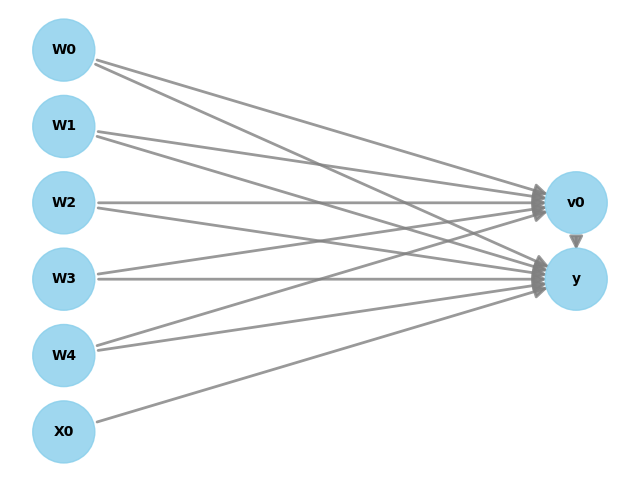

In [10]:
model.view_model()

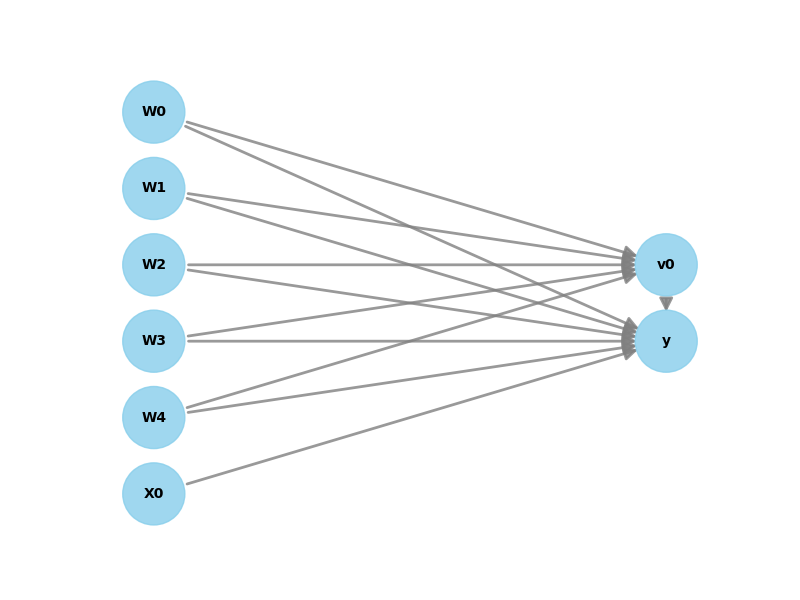

In [12]:
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

Aynı nedensel grafiği elde ediyoruz. Şimdi tanımlama ve tahmin daha önce olduğu gibi yapılıyor.

In [11]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

In [12]:
estimate = model.estimate_effect(identified_estimand,
                                    method_name="backdoor.linear_regression")
print(estimate)
print("Causal Estimate is " + str(estimate.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W1,W3,W2,W0,W4])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W3,W2,W0,W4,U) = P(y|v0,W1,W3,W2,W0,W4)

## Realized estimand
b: y~v0+W1+W3+W2+W0+W4+v0*X0
Target units: 

## Estimate
Mean value: 9.946564139159609
### Conditional Estimates
__categorical__X0
(-3.5349999999999997, -1.01]     9.489908
(-1.01, -0.412]                  9.771253
(-0.412, 0.0849]                 9.947147
(0.0849, 0.681]                 10.120959
(0.681, 3.764]                  10.403553
dtype: float64
Causal Estimate is 9.946564139159609


# Tahmini Çürütme

Şimdi elde edilen tahmini çürütmenin yollarına bakalım. Çürütme yöntemleri, her doğru tahmincinin geçmesi gereken testler sağlar. Yani bir tahminci çürütme testinde başarısız olursa (p değeri <0,05), bu tahmincide bir sorun olduğu anlamına gelir.

Tahminin doğru olduğunu doğrulayamayacağımızı, ancak belirli beklenen davranışları ihlal ederse reddedebileceğimizi unutmayın (bu, yanlışlanabilen ancak doğruluğu kanıtlanamayan bilimsel teorilere benzerdir). Aşağıdaki çürütme testleri şunlara dayanmaktadır: 

1) Değişmez dönüşümler: tahmini değiştirmemesi gereken verilerdeki değişiklikler. Sonucu orijinal verilerle değiştirilmiş veriler arasında önemli ölçüde değişen herhangi bir tahminci testi geçemez;

a. Rastgele Ortak Neden

b. Veri Alt Kümesi

2) Dönüşümleri geçersiz kılma: Veri değişikliğinden sonra, nedensel gerçek tahmin sıfırdır. Yeni verilerde sonucu sıfırdan önemli ölçüde değişen herhangi bir tahminci testi geçemez.

a. Plasebo Tedavisi


**Rastgele ortak neden değişkeni ekleme**

In [13]:
res_random=model.refute_estimate(identified_estimand, estimate, method_name="random_common_cause")
print(res_random)

Refute: Add a random common cause
Estimated effect:9.946564139159609
New effect:9.946563909238687
p value:0.94



**Tedaviyi rastgele (plasebo) bir değişkenle değiştirme**

In [14]:
res_placebo=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute", show_progress_bar=True)
print(res_placebo)

Refuting Estimates:   0%|          | 0/100 [00:00<?, ?it/s]

Refute: Use a Placebo Treatment
Estimated effect:9.946564139159609
New effect:0.0007562105620152337
p value:0.94



**Verilerin rastgele bir alt kümesinin kaldırılması**

Gördüğünüz gibi, eğilim puanı tabakalandırma tahmincisi (propensity score stratification estimator) çürütmelere karşı oldukça dayanıklıdır.

**Tekrarlanabilirlik (reproducability)**: Tekrarlanabilirlik için, aşağıda gösterildiği gibi herhangi bir çürütme yöntemine "random_seed" parametresi ekleyebilirsiniz.

**Paralelleştirme**: Çürütme sürecini hızlandırmak için yerleşik paralelleştirmeyi de kullanabilirsiniz. İş yükünü birden fazla CPU'ya yaymak için n_jobs değerini 1'den büyük bir değere ayarlayın veya tüm CPU'ları kullanmak için n_jobs=-1 değerini ayarlayın. Şu anda bu yalnızca random_common_cause, placebo_treatment_refuter ve data_subset_refuter için kullanılabilir.

In [15]:
res_subset=model.refute_estimate(identified_estimand, estimate,
                                 method_name="data_subset_refuter", 
                                 subset_fraction=0.9,
                                 random_seed=1,
                                 n_jobs=-1,
                                 verbose=10
                                 )
print(res_subset)
                                 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  48 out of 100 | elapsed:    4.1s remaining:    4.5s
[Parallel(n_jobs=-1)]: Done  59 out of 100 | elapsed:    4.2s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done  70 out of 100 | elapsed:    4.2s remaining:    1.7s


Refute: Use a subset of data
Estimated effect:9.946564139159609
New effect:9.94657510110556
p value:0.94



[Parallel(n_jobs=-1)]: Done  81 out of 100 | elapsed:    4.3s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  92 out of 100 | elapsed:    4.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.3s finished


**Gözlemlenemeyen ortak neden değişkeni ekleme**

Bu çürütme bir p-değeri döndürmez. Bunun yerine, tanımlayıcı varsayımlar (identify_effect'te kullanılır) geçerli değilse tahminin ne kadar hızlı değiştiğine dair bir duyarlılık testi sağlar. Özellikle, arka kapı varsayımının ihlaline duyarlılığı kontrol eder: tüm yaygın nedenlerin gözlemlendiği.

Bunu yapmak için, tedavi ve sonuç arasında ek bir ortak nedene sahip yeni bir veri kümesi oluşturur. Ortak nedenin etkisini yakalamak için, yöntem girdi olarak ortak nedenin tedavi ve sonuç üzerindeki etkisinin gücünü alır. Ortak nedenin etkilerine ilişkin bu girdilere dayanarak, tedavi ve sonuç değerlerini değiştirir ve ardından tahmin ediciyi yeniden çalıştırır. Umut, yeni tahminin gözlemlenmeyen ortak nedenin küçük bir etkisiyle büyük ölçüde değişmemesi ve gözlemlenmeyen herhangi bir karıştırıcıya karşı sağlamlık göstermesidir.

Bu prosedürü yorumlamanın bir diğer eşdeğer yolu, girdi verilerinde zaten gözlemlenmemiş karıştırıcının mevcut olduğunu varsaymaktır. Tedavi ve sonuç değerlerindeki değişiklik, orijinal verilerde mevcut olan gözlemlenmemiş ortak nedenin etkisini ortadan kaldırır. Daha sonra tahminciyi bu değiştirilmiş veriler üzerinde yeniden çalıştırmak doğru tanımlanmış tahmini sağlar ve gözlemlenmemiş ortak nedenin etkisinin bazı sınırlı değerleri için yeni tahmin ile orijinal tahmin arasındaki farkın çok yüksek olmadığını umuyoruz.

**Alan bilgisinin önemi**: Bu test, gözlemlenmeyen karıştırıcının etkisinin makul girdi değerlerini belirlemek için alan bilgisini gerektirir. İlk olarak, karıştırıcının tedavi ve sonuç üzerindeki etkisinin tek bir değeri için sonucu gösteriyoruz.

In [16]:
res_unobserved=model.refute_estimate(identified_estimand, estimate, method_name="add_unobserved_common_cause",
                                     confounders_effect_on_treatment="binary_flip", confounders_effect_on_outcome="linear",
                                    effect_strength_on_treatment=0.01, effect_strength_on_outcome=0.02)
print(res_unobserved)

Refute: Add an Unobserved Common Cause
Estimated effect:9.946564139159609
New effect:9.508087292589472



Gözlemlenemeyen karıştırıcının etkisi arttıkça eğilimi incelemek genellikle daha faydalıdır. Bunun için, varsayılan karıştırıcıların etkilerinin bir dizisini sağlayabiliriz. Çıktı, farklı gözlemlenemeyen karıştırıcılar altında tahmini etkilerin (min, maks) aralığıdır.

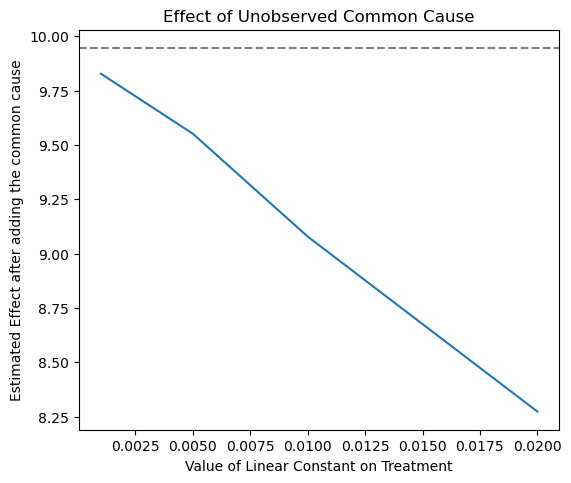

Refute: Add an Unobserved Common Cause
Estimated effect:9.946564139159609
New effect:(8.273722767761573, 9.827546988085686)



In [17]:
res_unobserved_range=model.refute_estimate(identified_estimand, estimate, method_name="add_unobserved_common_cause",
                                     confounders_effect_on_treatment="binary_flip", confounders_effect_on_outcome="linear",
                                    effect_strength_on_treatment=np.array([0.001, 0.005, 0.01, 0.02]), effect_strength_on_outcome=0.01)
print(res_unobserved_range)

Yukarıdaki grafik, tedavi üzerindeki varsayılan karıştırıcı etki arttıkça tahminin nasıl azaldığını göstermektedir. Alan bilgisine göre, tedavi üzerindeki maksimum olası karıştırıcı etkiyi bilebiliriz. Etkinin sıfırın ötesine geçmediğini gördüğümüzden, tedavi v0'ın nedensel etkisinin pozitif olduğu sonucuna güvenle varabiliriz.

Ayrıca, hem tedavi hem de sonuç üzerindeki karıştırıcı etkiyi değiştirebiliriz. Bir ısı haritası elde ederiz.

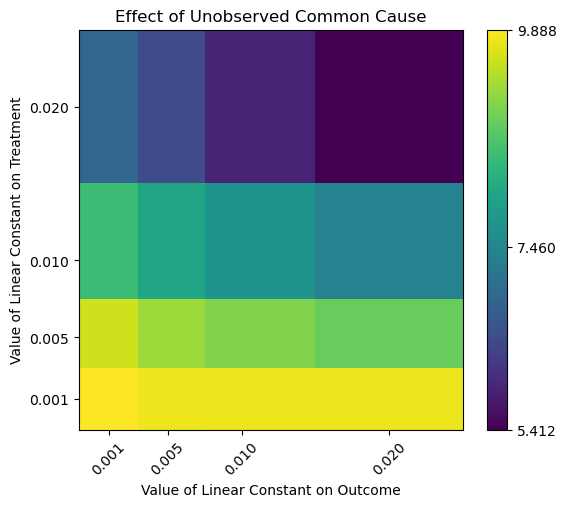

Refute: Add an Unobserved Common Cause
Estimated effect:9.946564139159609
New effect:(5.412143710494112, 9.888389790826572)



In [18]:
res_unobserved_range=model.refute_estimate(identified_estimand, estimate, method_name="add_unobserved_common_cause",
                                           confounders_effect_on_treatment="binary_flip", confounders_effect_on_outcome="linear",
                                           effect_strength_on_treatment=[0.001, 0.005, 0.01, 0.02],
                                           effect_strength_on_outcome=[0.001, 0.005, 0.01,0.02])
print(res_unobserved_range)

**Etki gücü parametrelerini otomatik olarak çıkarma (Automatically inferring effect strength parameters)**. Son olarak, DoWhy etki gücü parametrelerinin otomatik olarak seçilmesini destekler. Bu, gözlemlenmeyen karıştırıcının tedavi veya sonuç üzerindeki etkisinin gözlemlenen herhangi bir karıştırıcıdan daha güçlü olamayacağı varsayımına dayanmaktadır. Yani, en azından en alakalı karıştırıcı için veri topladık. Durum buysa, effect_strength_on_treatment ve effect_strength_on_outcome aralığını gözlemlenen karıştırıcıların etki gücüyle sınırlayabiliriz. Gözlemlenmeyen karıştırıcının etki gücünün gözlemlenen en yüksek kadar mı yoksa onun bir kesri kadar mı olması gerektiğini belirten ek bir isteğe bağlı parametre vardır. İsteğe bağlı effect_fraction_on_treatment ve effect_fraction_on_outcome parametrelerini kullanarak bunu ayarlayabilirsiniz. Varsayılan olarak, bu iki parametre 1'dir.

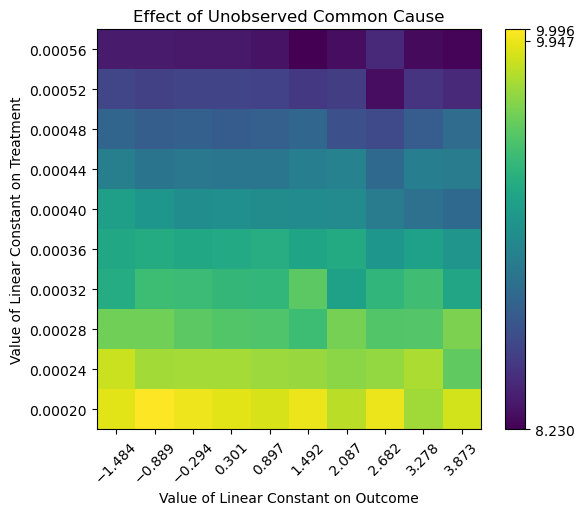

Refute: Add an Unobserved Common Cause
Estimated effect:9.946564139159609
New effect:(8.230316378840337, 9.996289975206686)



In [19]:
res_unobserved_auto = model.refute_estimate(identified_estimand, estimate, method_name="add_unobserved_common_cause",
                                           confounders_effect_on_treatment="binary_flip", confounders_effect_on_outcome="linear")
print(res_unobserved_auto)

Sonuç: Gözlemlenmeyen karıştırıcı faktörün, tedaviyi veya sonucu gözlemlenen herhangi bir karıştırıcı faktörden daha güçlü bir şekilde etkilemediği varsayıldığında, nedensel etkinin pozitif olduğu sonucuna varılabilir.